In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev136+g2d2326118.d20221108 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20 import MapDatasetNuisance
#from  my_fit_20 import Fit


from scipy.optimize import curve_fit

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : Iwo00C-G 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : VBdAyGZI
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model t

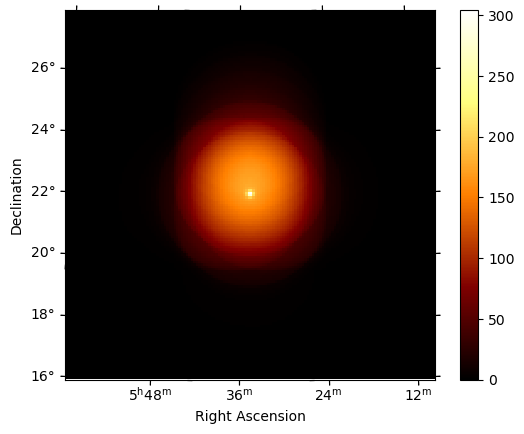

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models_input = Models(source_model)
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

asimov = True
if asimov:
    dataset_standard.counts = dataset_standard.npred()
    
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(    "spatial binsize = ",    binsize)

print(dataset_standard)
fit = Fit()
result = fit.run(dataset_standard)

In [10]:
shift = 0.8
dataset_shifted = MapDataset.read(f"stacked_shifted{shift}.fits.gz")

#copy the standard dataset 
#dataset_shifted = dataset_standard.copy()
models_shifted = Models(source_model)
bkg_model_shifted = FoVBackgroundModel(dataset_name=dataset_shifted.name)
bkg_model_shifted.parameters['tilt'].frozen  = False
models_shifted.append(bkg_model_shifted)
dataset_shifted.models = models_shifted




Text(0, 0.5, 'Predicted Flux [1 / (cm2 s)]')

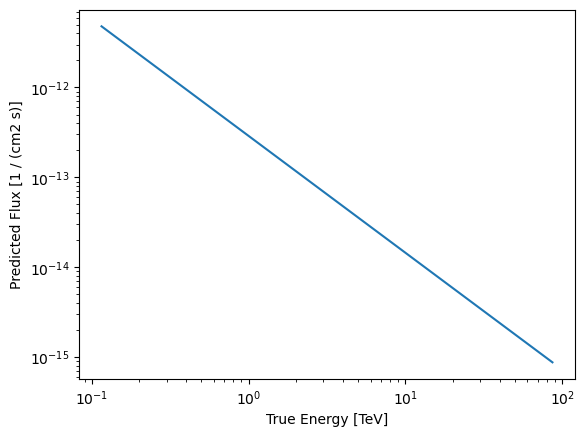

In [11]:
# Computing the correct flux with the original exposure
true_energy_geom = dataset_shifted.exposure.geom
compute_flux = dataset_shifted.models['Source'].integrate_geom(true_energy_geom)
compute_flux_e = compute_flux.data.sum(axis=2).sum(axis=1)
plt.plot(true_energy_geom.axes[0].center.value, compute_flux_e)
plt.loglog()
plt.xlabel("True Energy [TeV]")
plt.ylabel(f"Predicted Flux [{compute_flux.unit}]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


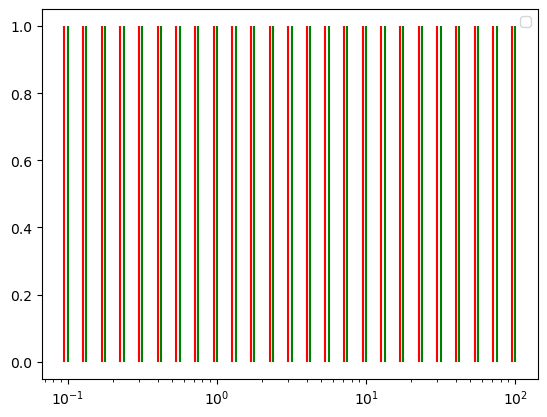

In [12]:
# shfiting the energy axis and creating a new geom out of it
shift = 0.95
shifted_eaxis = MapAxis(nodes = true_energy_geom.axes[0].edges * shift,
                        interp='log', 
                        name=true_energy_geom.axes[0].name, 
                        node_type='edges')
true_energy_geom_shifted = true_energy_geom.copy().to_image()
true_energy_geom_shifted = true_energy_geom_shifted.to_cube([shifted_eaxis])


fig = plt.figure()
for e in true_energy_geom_shifted.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in true_energy_geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()

Text(0, 0.5, 'Predicted Flux [1 / (cm2 s)]')

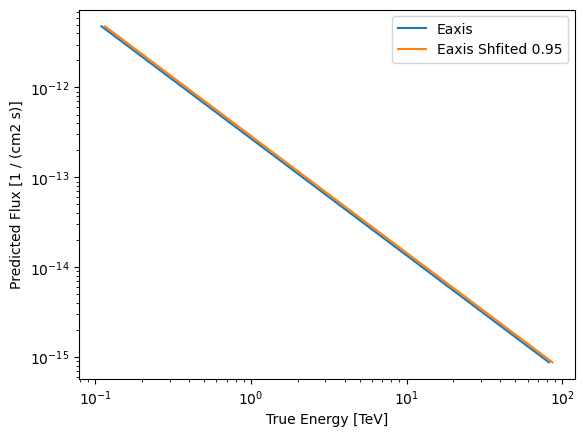

In [8]:
# compute the flux now with this shifted geom
compute_flux_shifted = dataset_shifted.models['Source'].integrate_geom(true_energy_geom_shifted)
compute_flux_e_shifted = compute_flux.data.sum(axis=2).sum(axis=1)
plt.plot(true_energy_geom_shifted.axes[0].center.value, compute_flux_e_shifted,
        label = "Eaxis")
plt.plot(true_energy_geom.axes[0].center.value, compute_flux_e,
        label = f"Eaxis Shfited {shift}")

plt.loglog(); plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel(f"Predicted Flux [{compute_flux.unit}]")

[]

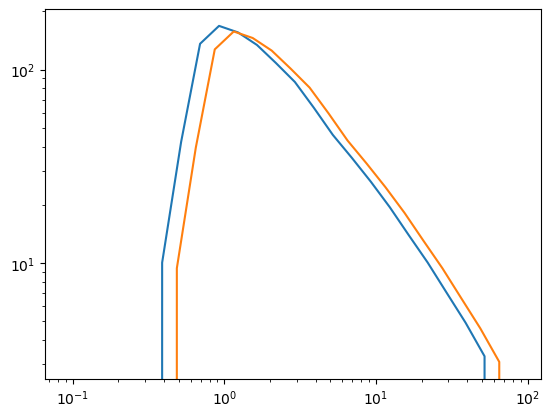

In [9]:
ex_shifted = Map.from_geom(true_energy_geom_shifted,
                             data = dataset_shifted.exposure.data,
                          unit = dataset_shifted.exposure.unit)
ex_orgi = dataset_shifted.exposure.copy()

dataset_shifted.exposure = ex_shifted

npred_signal_shifted  = dataset_shifted.npred_signal()
npred_signal_shifted_e = npred_signal_shifted.data.sum(axis=2).sum(axis=1)


npred_signal  = dataset_standard.npred_signal()
npred_signal_e = npred_signal.data.sum(axis=2).sum(axis=1)

plt.plot(npred_signal_shifted.geom.axes[0].center.value, npred_signal_shifted_e)
plt.plot(npred_signal.geom.axes[0].center.value, npred_signal_e)

plt.loglog()

Shfiting the eaxis before the convolving, is just the same as scaling up and down, i.e. changing the amplitude